# 6. wiag_to_factgrid.ipynb

## **Office Creation Notebook**
This notebook takes data from wiag as the primary source, then joins it with
* institution data from factgrid
* diocese data from factgrid
* role data from wiag
* role data from factgrid
and then creates a final quickstatements csv at the end to be uploaded the factgrid.

At every join operation, there is the possibility that some data in wiag has no corresponding data in factgrid.
The notebook create a quickstatements csv to create the missing data whenever this happens.
After creating the csv, it removes all the missing entries and moves on the next step (these cells are marked with two stars **). There are two possible routes to execute this notebook:
1. [Import the csv files to factgrid](https://database.factgrid.de/quickstatements/#/batch) whenever one is generated, and then run the notebook from the beginning up to that point. 
2. Do not create any factgrid entries except at the very last step. This flow works since all missing entries are ignored after their corresponding csv file is generated.

This is explained with the diagram below. The description of the shapes is below:
* Diamonds: The diamonds indicate a join operation. After this operation you have entries that have been successfully added information to.
* Circles: The circles indicate the records that were successfully joined. This means that there was more information added to the orignal record.
* Rectangle: The rectanges indicate the records that failed the join operation.

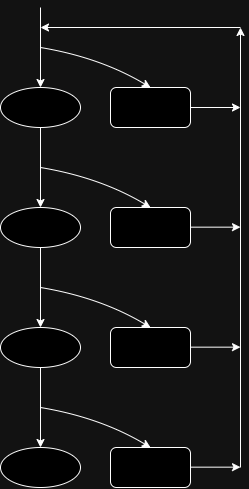

The large arrow on the right that goes back up indicates that after a join operation is failed, you could use the generated files to fix the problems with the records and start from the top again.

So the first route to execute this notebook is to follow the square blocks as soon as you encounter one and then take the arrow back to the start. The second route is to follow the circle blocks and go down until the final csv file is generated.

Note: a missing feature of this notebook is that it does not check for duplicates when adding office information for the entries. This should be a feature that should be included the notebook soon.

## Library Installation
Run the line below (without the # symbol) to install pandas (if not already installed)

In [50]:
# !py -m pip install pandas

In [51]:
import requests
import csv
import os
import pandas as pd
import json
import re
import time
from datetime import datetime, timedelta
import math
import traceback

In [52]:
input_path = "C:\\Users\\khan32\\Documents\\factgrid_py\\"
# input_path = "."

In [53]:
output_path = input_path

In [54]:
place_name = "Bamberg"

In [55]:
today_string = datetime.now().strftime('%Y-%m-%d')

Export the results from the query from https://vwebfile.gwdg.de/phpmyadmin
```sql
SELECT * FROM role r 
LEFT JOIN (
    select * from url_external where authority_id = 42
) u on r.id = u.item_id;
```  
from the main wiag database in the csv format.

Rename it to include the date. An example filename would be `role_2024_04_24.csv`

In [56]:
input_file = f"role_2024_07_08.csv"
input_path_file = os.path.join(input_path, input_file)
wiag_roles_df = pd.read_csv(input_path_file, names=['id', 'note', 'name', 'comment', 'gs_reg_id', 'generic_term', 'plural', 'definition', 'role_gp_fg_id', 'gender', 'lang', 'role_group_id','r_id','item_id','r_note','authority_id','role_fg_id','r_comment'])
len(wiag_roles_df)

263

### Download data from wiag
https://wiag-vokabulare.uni-goettingen.de/query/can

In [57]:
input_file = f"WIAG-Domherren-DB-Ämter_2024-07-23_Bamberg.csv"
input_path_file = os.path.join(input_path, input_file)
role_all_df = pd.read_csv(input_path_file, sep=';')
len(role_all_df)

3108

In [58]:
last_modified = datetime.fromtimestamp(os.path.getmtime(input_path_file))
now = datetime.now()
assert last_modified.day == now.day and last_modified.month == now.month, f"The file was last updated on {last_modified.strftime('%d.%m')}"

AssertionError: The file was last updated on 23.07

### Troubleshooting: Old file used
You get an error when you run the line above if the file was not updated today.
Suggested solutions: 
* update the file again by downloading it again
* if you downloaded the data today, check the file name in input_file. It's pointing to a file that has old data.
* (not recommended) continue if you are sure that you need to use old data. This is something that the developer might want to do.

# Download data from factgrid

Troubleshooting: If any of the following requests to factgrid fail, try re running the cells.

In [59]:
url = 'https://database.factgrid.de/sparql'
query = (
    """SELECT ?item ?gsn WHERE {
  ?item wdt:P471 ?gsn
}
"""
)
# SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }

# make request: 
r = requests.get(url, params={'query': query}, headers={"Accept": "application/json"})
data = r.json()
factgrid_institution_df = pd.json_normalize(data['results']['bindings'])

len(factgrid_institution_df)

276

In [60]:
url = 'https://database.factgrid.de/sparql'
query = (
"""
SELECT ?item ?wiagid ?label ?alternative WHERE {
  ?item wdt:P2/wdt:P3* wd:Q164535.
  #?item schema:description ?itemDesc.
  ?item rdfs:label ?label.
  OPTIONAL {?item schema:description ?itemDesc.}
  OPTIONAL {?item skos:altLabel ?alternative. }
  OPTIONAL {?item wdt:P601 ?wiagid.}
  FILTER(LANG(?label) in ("en", "de"))
}
"""
)


# version 2
# SELECT ?item ?wiagid (group_concat(DISTINCT ?label; separator=',') as ?labels) (group_concat(DISTINCT ?itemDesc; separator=',') as ?itemDescs) (group_concat(DISTINCT ?alternative ; separator=',') as ?alternatives) WHERE {
#   ?item wdt:P2/wdt:P3* wd:Q164535.
#   ?item schema:description ?itemDesc.
#   ?item rdfs:label ?label.
#   OPTIONAL {?item schema:description ?itemDesc.}
#   OPTIONAL {?item skos:altLabel ?alternative. }
#   OPTIONAL {?item wdt:P601 ?wiagid.}
#   FILTER(LANG(?label) in ("en", "de"))
# }
# GROUP BY ?item ?wiagid

# SELECT ?item ?wiagid WHERE {
#   ?item wdt:P2/wdt:P3* wd:Q164535.
#   ?item wdt:P601 ?wiagid
# }
# SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }

# make request: 
r = requests.get(url, params={'query': query}, headers={"Accept": "application/json"})
data = r.json()
factgrid_diocese_df = pd.json_normalize(data['results']['bindings'])

len(factgrid_diocese_df)

1338

In [61]:
url = 'https://database.factgrid.de/sparql'
query = (
"""
SELECT ?item ?label WHERE {
  ?item wdt:P2 wd:Q257052.
  ?item rdfs:label ?label.
  FILTER(LANG(?label) in ("de"))
}
"""
)

r = requests.get(url, params={'query': query}, headers={"Accept": "application/json"})
data = r.json()
factgrid_inst_roles_df = pd.json_normalize(data['results']['bindings'])

len(factgrid_inst_roles_df)

4499

# Clean Factgrid data

In [62]:
# extract out q id
def extract_qid(df, column):
    df[column] = df[column].map(lambda x: x.strip('https://database.factgrid.de/entity/'))
 
#factgrid_df['item.value'] = factgrid_df['item.value'].map(lambda x: x.strip('https://database.factgrid.de/entity/'))

# drop irrelevant columns
def drop_type_columns(df):
    df.drop(columns=[column for column in df.columns if column.endswith('type')], inplace=True)
    df.drop(columns=[column for column in df.columns if column.endswith('xml:lang')], inplace=True)

In [63]:
extract_qid(factgrid_institution_df, 'item.value')
extract_qid(factgrid_diocese_df, 'item.value')
extract_qid(factgrid_inst_roles_df, 'item.value')

In [64]:
drop_type_columns(factgrid_institution_df)
drop_type_columns(factgrid_diocese_df)
drop_type_columns(factgrid_inst_roles_df)

In [65]:
# rename columns
factgrid_institution_df.columns = ['fg_institution_id', 'fg_gsn_id']
factgrid_diocese_df.columns = ["fg_diocese_id", "dioc_label", "dioc_alt", "dioc_wiag_id"]
factgrid_inst_roles_df.columns = ["fg_inst_role_id", "inst_role"]

In [66]:
# clean the diocese alts by removing BITECA and BETA entries 
factgrid_diocese_df['dioc_alt'] = factgrid_diocese_df['dioc_alt'].replace(['^BITECA.*', '^BETA.*'], '', regex=True)

In [67]:
role_all_df.head()

,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,date_begin,date_end,date_sort_key,GND,GSN,FactGrid
0,WIAG-Pers-EPISCGatz-04349-001,150920,Domscholaster,Leitungsamt Domstift,Dignitary of a cathedral chapter,Q648232,Domstift Bamberg,3492.0,NaN,NaN,1007,1021,1007150,135729211,NaN,Q652454
1,WIAG-Pers-EPISCGatz-04349-001,150922,Bischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Bistum Lüttich,WIAG-Inst-DIOCGatz-046-001,1021,1025,1021150,135729211,NaN,Q652454
2,WIAG-Pers-EPISCGatz-05072-001,150924,Dompropst,Leitungsamt Domstift,Dignitary of a cathedral chapter,Q648232,Domstift Bamberg,3492.0,NaN,NaN,1014,1016,1014150,120912619,062-01186-001,Q653844
3,WIAG-Pers-EPISCGatz-05072-001,150926,Erzbischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Erzbistum Trier,WIAG-Inst-DIOCGatz-030-001,1016,1047,1016150,120912619,062-01186-001,Q653844
4,WIAG-Pers-EPISCGatz-04050-001,150928,Bischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Bistum Eichstätt,WIAG-Inst-DIOCGatz-006-001,(1014?) 1015,1019,1014150,136969143,059-00710-001,Q652691


In [68]:
factgrid_institution_df.head()

,fg_institution_id,fg_gsn_id
0,Q164131,2041
1,Q898060,3006
2,Q898054,3007
3,Q898086,3008
4,Q898077,60027


In [69]:
factgrid_diocese_df.head()

,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id
0,Q153246,Bistum Worms,Diözese Worms,WIAG-Inst-DIOCGatz-032-001
1,Q153246,Diocese of Worms,Diözese Worms,WIAG-Inst-DIOCGatz-032-001
2,Q153247,Bistum Würzburg,Diözese Würzburg,WIAG-Inst-DIOCGatz-033-001
3,Q153247,Diocese of Würzburg,Diözese Würzburg,WIAG-Inst-DIOCGatz-033-001
4,Q153248,Bistum Oldenburg,Diözese Oldenburg,WIAG-Inst-DIOCGatz-044-001


In [70]:
factgrid_inst_roles_df.head()

,fg_inst_role_id,inst_role
0,Q172314,Generalvikar der Erzdiözese Prague
1,Q172315,Generalvikar der Diözese Strasbourg
2,Q172316,Generalvikar der Diözese Trento
3,Q172317,Generalvikar der Diözese Utrecht
4,Q172318,Generalvikar der Diözese Vienna


In [71]:
print(len(wiag_roles_df))
wiag_roles_df.head()

263


,id,note,name,comment,gs_reg_id,generic_term,plural,definition,role_gp_fg_id,gender,lang,role_group_id,r_id,item_id,r_note,authority_id,role_fg_id,r_comment
0,1,NaN,Titularkönig,NaN,NaN,NaN,NaN,NaN,NaN,männlich,de,32.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,Abtbischof,NaN,NaN,NaN,NaN,NaN,Q648236,männlich,de,33.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,Administrator des Bistums,Factgrid = Bistumsadministrator,NaN,NaN,NaN,Ein Bistumsadministrator (auch: Diözesanadmini...,Q648236,männlich,de,33.0,1298102.0,3.0,NaN,42.0,Q902170,NaN
3,4,NaN,Administrator des Erzbistums,Factgrid = Bistumsadministrator,NaN,NaN,NaN,NaN,Q648236,männlich,de,33.0,1298104.0,4.0,NaN,42.0,Q902170,NaN
4,5,NaN,Administrator des Fürstbischofs,Factgrid = Bistumsadministrator,NaN,NaN,NaN,Ein Bistumsadministrator (auch: Diözesanadmini...,Q648236,männlich,de,33.0,1298982.0,5.0,NaN,42.0,Q902170,NaN


In [72]:
factgrid_institution_df['fg_gsn_id'] = pd.to_numeric(factgrid_institution_df['fg_gsn_id'], downcast='float')

In [73]:
fg_gp = factgrid_institution_df.groupby('fg_gsn_id').count()
duplicate_fg_entries = factgrid_institution_df[factgrid_institution_df['fg_gsn_id'].isin(list(fg_gp[fg_gp['fg_institution_id'] > 1].index))]
if not duplicate_fg_entries.empty:
    print(duplicate_fg_entries)
    raise f"There are possible institution duplicates on factgrid."

## Troubleshooting: possible institution duplicates
This can be caused by a simple human error on factgrid. 
The best solution is to use the factgrid ids printed above and resolve the duplicates.

In case you want to ignore the duplicates, uncomment the code below by removing the leading '# ' (keyboard shortcut 'ctrl + /') and run it.

In [74]:
# factgrid_institution_df = factgrid_institution_df[~factgrid_institution_df['fg_gsn_id'].isin(duplicate_fg_entries['fg_gsn_id'].to_list())]

# Add institution or diocese for roles that need them

The code cells below will go through the role data from wiag and check if there is missing diocese or institution on factgrid.
It then uses this information to create quickstatements csvs to create such entries on factgrid.

These lists below allow the code below to identify if the role is missing an institution or if the role doesn't require one at all.

* The `unbound_role_groups` list has the role_groups that are not bound to a place at all.

* The `diocese_role_gropus` list has the role_gropus that are bound to a diocese but not an institution.
  * `diocese_role_group_exeption_roles` has roles that belong to this group but are still bound to an institution.

Please add more role_groups to the list if necessary.

In [75]:
unbound_role_groups = [
    'Kurienamt',
    'Papst',
    'Kardinal',
]
diocese_role_groups = [
    'Oberstes Leitungsamt Diözese',
    'Leitungsamt Diözese',
]
diocese_role_group_exeption_roles = [
    '',
]

### Add diocese information from factgrid
For each entry in the input dataframe, the associated diocese is searched in the factgrid_diocese_df dataframe.

The dioceses is found by 3 queries. If the earliear query finds a match, the following query does nothing. The order of the criteria for the search query is as follows: 
* wiag id (wiag) => wiag id (factgrid)
* diocese name (wiag) => diocese label (factgrid)
* diocese name (wiag) => diocese alt label (factgrid)

In [76]:
# lookup for the diocese by the diocese_id, then diocese labels, then diocese alts
# TODO optimize the code below
def join_dioceses(input_df):
    rows = []
    for _, row in input_df.iterrows():
        search_row = pd.Series({'fg_diocese_id':None, 'dioc_label':None, 'dioc_alt':None, 'dioc_wiag_id':None})

        # NOTE: in the following three code blocks only the query changes.
        # this could be refactored somehow without running the query when defining it
        if not search_row['fg_diocese_id']:
            query = factgrid_diocese_df[factgrid_diocese_df['dioc_wiag_id'] == row['diocese_id']]
            if not query.empty:
                search_row = query.head(1).squeeze(axis=0)
    
        if not search_row['fg_diocese_id']:
            query = factgrid_diocese_df[factgrid_diocese_df['dioc_label'] == row['diocese']]
            if not query.empty:
                search_row = query.head(1).squeeze(axis=0)
    
        if not search_row['fg_diocese_id']:
            query = factgrid_diocese_df[factgrid_diocese_df['dioc_alt'] == row['diocese']]
            if not query.empty:
                search_row = query.head(1).squeeze(axis=0)
        rows.append(row.combine_first(search_row))
    
    dioc_joined_df = pd.DataFrame(rows)
    dioc_joined_df = dioc_joined_df[[*input_df.columns, *factgrid_diocese_df.columns]]
    
    return dioc_joined_df

In [77]:
# join with fg institutions
role_inst_df = role_all_df.merge(
    factgrid_institution_df, indicator = '_inst_merge', how='left', left_on='institution_id', right_on='fg_gsn_id', suffixes=('_wiag', '_institute_fg')
)

# select all entries that should contain a institution on factgrid but don't have it after the join operation
missing_inst_df = role_inst_df[role_inst_df['_inst_merge'] != 'both'][
    ~role_inst_df['role_group'].isin(unbound_role_groups) & 
    ~role_inst_df['role_group'].isin(diocese_role_groups)
]

C:\Users\khan32\AppData\Local\Temp\ipykernel_10076\477877611.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  missing_inst_df = role_inst_df[role_inst_df['_inst_merge'] != 'both'][


In [78]:
# join with fg dioceses
# this cell can take a while to execute
role_inst_dioc_df = join_dioceses(role_inst_df)

In [79]:
# select all entries that should contain a diocese on factgrid but don't have it after the join operation
missing_dioc_df = role_inst_dioc_df[
    role_inst_dioc_df['fg_diocese_id'].isna() & 
    role_inst_dioc_df['role_group'].isin(diocese_role_groups) &
    ~role_inst_dioc_df['role_group'].isin(unbound_role_groups) & 
    ~role_inst_dioc_df['name'].isin(diocese_role_group_exeption_roles)
]

In [80]:
all_missing_entries = pd.concat([missing_inst_df, missing_dioc_df])
print(len(all_missing_entries))
all_missing_entries.head()

10


,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,...,GND,GSN,FactGrid,fg_institution_id,fg_gsn_id,_inst_merge,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id
22,WIAG-Pers-CANON-53022-001,148984,Mönch,Amt Kloster,Monastery affiliate,Q648227,"Benediktinerkloster Michelsberg, Bamberg",60042.0,NaN,NaN,...,118633406,009-01734-001,Q946230,NaN,NaN,left_only,NaN,NaN,NaN,NaN
23,WIAG-Pers-CANON-53022-001,148986,Abt,Oberstes Leitungsamt Kloster,Monastery member with a leadership position,Q648233,Benediktinerkloster Ebersberg,60077.0,NaN,NaN,...,118633406,009-01734-001,Q946230,NaN,NaN,left_only,NaN,NaN,NaN,NaN
48,WIAG-Pers-CANON-53030-001,151006,Mönch,Amt Kloster,Monastery affiliate,Q648227,Reichsabtei Hersfeld (Benediktiner),30002.0,NaN,NaN,...,10095135X,030-03349-001,Q946233,NaN,NaN,left_only,NaN,NaN,NaN,NaN
78,WIAG-Pers-CANON-53094-001,151116,Domherr,Amt Domstift,Cleric of a cathedral chapter,Q648226,NaN,NaN,NaN,NaN,...,NaN,NaN,Q946855,NaN,NaN,left_only,NaN,NaN,NaN,NaN
90,WIAG-Pers-EPISCGatz-04778-001,158654,Abt,Oberstes Leitungsamt Kloster,Monastery member with a leadership position,Q648233,Benediktinerkloster Biburg,60058.0,NaN,NaN,...,118687433,067-01904-001,Q653959,NaN,NaN,left_only,NaN,NaN,NaN,NaN


### Check entries that could be in the exception list (diocese_role_group_exeption_roles)

In [81]:
missing_dioc_df[~missing_dioc_df['name'].isin(['Bischof', 'Koadjutor', 'Erzbischof'])]

,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,...,GND,GSN,FactGrid,fg_institution_id,fg_gsn_id,_inst_merge,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id
1466,WIAG-Pers-CANON-49040-001,140500,Archidiakon,Leitungsamt Diözese,Head of an (arch)diocese,Q648236,Domstift Würzburg,3502.0,NaN,NaN,...,NaN,007-01947-001,Q883551,Q400557,3502.0,both,None,None,None,None
1712,WIAG-Pers-CANON-44984-001,155956,Administrator,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,Zisterzienserkloster Waldsassen,60411.0,NaN,NaN,...,119204150,NaN,Q508374,Q898099,60411.0,both,None,None,None,None


## Check entries that have no role group in wiag

In [82]:
missing_inst_df[missing_inst_df['role_group'].isna()]

,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,date_begin,date_end,date_sort_key,GND,GSN,FactGrid,fg_institution_id,fg_gsn_id,_inst_merge


## Entries that have a missing id required for the join
Please manually inspect all the entries that are shown by the code cells below

#### Entries that have a missing institution id

In [83]:
missing_inst_df[missing_inst_df['institution_id'].isna()]

,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,date_begin,date_end,date_sort_key,GND,GSN,FactGrid,fg_institution_id,fg_gsn_id,_inst_merge
78,WIAG-Pers-CANON-53094-001,151116,Domherr,Amt Domstift,Cleric of a cathedral chapter,Q648226,NaN,NaN,NaN,NaN,vor 1100,NaN,1100100,NaN,NaN,Q946855,NaN,NaN,left_only


#### Entries that have a missing institution id but have an institution string

In [84]:
missing_inst_df[
    missing_inst_df['institution_id'].isna() & 
    ~missing_inst_df['institution'].isna()
]

,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,date_begin,date_end,date_sort_key,GND,GSN,FactGrid,fg_institution_id,fg_gsn_id,_inst_merge


#### Entries that have a missing diocese id

In [85]:
missing_dioc_df[missing_dioc_df['diocese_id'].isna()]

,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,...,GND,GSN,FactGrid,fg_institution_id,fg_gsn_id,_inst_merge,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id
1466,WIAG-Pers-CANON-49040-001,140500,Archidiakon,Leitungsamt Diözese,Head of an (arch)diocese,Q648236,Domstift Würzburg,3502.0,NaN,NaN,...,NaN,007-01947-001,Q883551,Q400557,3502.0,both,None,None,None,None
1633,WIAG-Pers-CANON-49049-001,39046,Koadjutor,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,"Benediktinerkloster St. Salvator, Fulda",30121.0,NaN,NaN,...,124223443,047-00717-001,Q883554,Q898017,30121.0,both,None,None,None,None
1712,WIAG-Pers-CANON-44984-001,155956,Administrator,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,Zisterzienserkloster Waldsassen,60411.0,NaN,NaN,...,119204150,NaN,Q508374,Q898099,60411.0,both,None,None,None,None


#### Entries that have a missing diocese id but a diocese string

In [86]:
missing_dioc_df[
    missing_dioc_df['diocese_id'].isna() & 
    ~missing_dioc_df['diocese'].isna()
]

,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,...,GND,GSN,FactGrid,fg_institution_id,fg_gsn_id,_inst_merge,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id


# Create the missing institutions on factgrid here

In [87]:
print(len(missing_inst_df))
missing_kloester_df = missing_inst_df[
    ~missing_inst_df['institution_id'].isna()
]
print(len(missing_kloester_df))
missing_kloester_df.head()

# get all institutions with a kloster id
# missing_kloester_df = null_entries[
#     ~(pd.isna(null_entries['institution_id']) |
#     pd.isna(null_entries['institution']))
# ][null_entries.columns[:-7]]
# len(missing_kloester_df)

6
5


,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,date_begin,date_end,date_sort_key,GND,GSN,FactGrid,fg_institution_id,fg_gsn_id,_inst_merge
22,WIAG-Pers-CANON-53022-001,148984,Mönch,Amt Kloster,Monastery affiliate,Q648227,"Benediktinerkloster Michelsberg, Bamberg",60042.0,NaN,NaN,vor 1048,NaN,1048100,118633406,009-01734-001,Q946230,NaN,NaN,left_only
23,WIAG-Pers-CANON-53022-001,148986,Abt,Oberstes Leitungsamt Kloster,Monastery member with a leadership position,Q648233,Benediktinerkloster Ebersberg,60077.0,NaN,NaN,1048,1085,1048150,118633406,009-01734-001,Q946230,NaN,NaN,left_only
48,WIAG-Pers-CANON-53030-001,151006,Mönch,Amt Kloster,Monastery affiliate,Q648227,Reichsabtei Hersfeld (Benediktiner),30002.0,NaN,NaN,1058,NaN,1058150,10095135X,030-03349-001,Q946233,NaN,NaN,left_only
90,WIAG-Pers-EPISCGatz-04778-001,158654,Abt,Oberstes Leitungsamt Kloster,Monastery member with a leadership position,Q648233,Benediktinerkloster Biburg,60058.0,NaN,NaN,1133,NaN,1133150,118687433,067-01904-001,Q653959,NaN,NaN,left_only
1778,WIAG-Pers-CANON-49085-001,146368,Komtur,Leitungsamt Ordensniederlassung,Conventual with a leadership position in the C...,Q648234,"Templerkommende, dann Johanniterkommende Mainz",40160.0,NaN,NaN,vor 1559,NaN,1559100,NaN,NaN,Q900454,NaN,NaN,left_only


Creates a file with the name institution_creation_\<date\>.csv

Fill in the empty columns of the file and then use the file on quickstatements.

In [88]:
create_institution_factgrid_df = missing_kloester_df[['institution', 'institution_id']].copy()
create_institution_factgrid_df.groupby('institution_id')
create_institution_factgrid_df.columns = ['Lde', 'P471']
create_institution_factgrid_df.drop_duplicates('P471', inplace=True)
create_institution_factgrid_df['P471'] = create_institution_factgrid_df['P471'].astype(int)
create_institution_factgrid_df.insert(0, column='qid', value='')
create_institution_factgrid_df.insert(2, column='Les', value='')
create_institution_factgrid_df.insert(2, column='Lfr', value='')
create_institution_factgrid_df.insert(2, column='Len', value='')
create_institution_factgrid_df.insert(6, column='Den', value='')
create_institution_factgrid_df.insert(6, column='Dde', value='')
create_institution_factgrid_df['P131'] = 'Q153178'
create_institution_factgrid_df.set_index('qid')
create_institution_factgrid_df.to_csv(os.path.join(output_path, f'institution_creation_{today_string}.csv'), index=False, sep=';')
create_institution_factgrid_df

,qid,Lde,Len,Lfr,Les,P471,Dde,Den,P131
22,,"Benediktinerkloster Michelsberg, Bamberg",,,,60042,,,Q153178
23,,Benediktinerkloster Ebersberg,,,,60077,,,Q153178
48,,Reichsabtei Hersfeld (Benediktiner),,,,30002,,,Q153178
90,,Benediktinerkloster Biburg,,,,60058,,,Q153178
1778,,"Templerkommende, dann Johanniterkommende Mainz",,,,40160,,,Q153178


In [89]:
# TODO: sent ouput to file instead of stdout

# for _, row in null_entries[null_entries['diocese'].notnull()][['diocese', 'diocese_id']].iterrows():
#     print("CREATE")
#     print('\t'.join(['LAST', 'Lde', f'"{row["diocese"]}"']))
#     print('\t'.join(['LAST', 'P2', 'Q153166']))

#     print('\t'.join(['LAST', 'P131', 'Q153178']))
#     if type(row['diocese_id']) == str:
#         print('\t'.join(['LAST', 'P601', f'"{row["diocese_id"]}"']))

In [90]:
# missing_institution_diocese_on_factgrid_df.to_csv('no_institution_or_dioc_on_fg_bamberg.csv', sep=';')

## Remove all missing (institution and diocese) entries now **
The code below removes all the entries that failed the join with the factgrid institution and diocese join above.

In [91]:
print(len(role_inst_dioc_df))
print(len(all_missing_entries))
dioc_joined_df = role_inst_dioc_df.loc[
    role_inst_dioc_df.index.difference(all_missing_entries.index)
]
dioc_joined_df = dioc_joined_df.drop('_inst_merge', axis=1)
print(len(dioc_joined_df))

3108
10
3098


# Add role factgrid id
Note: This role does not include the institution information. ie, it adds factgrid ids for roles like 'archbishop' and not 'archbishop of trier'

The part of the script below could be used to create quickstatements for career statements.

In [92]:
print(len(dioc_joined_df))
joined_df = dioc_joined_df.merge(
    wiag_roles_df[['name', 'role_fg_id']].drop_duplicates('name'), # TODO: ask for how to handle the duplicates here
    indicator='_role_merge', how='left', left_on='name', right_on='name', suffixes=('_wiag', '_institute_fg')
)
print(len(joined_df))
joined_df.head()

3098
3098


,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,...,GSN,FactGrid,fg_institution_id,fg_gsn_id,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id,role_fg_id,_role_merge
0,WIAG-Pers-EPISCGatz-04349-001,150920,Domscholaster,Leitungsamt Domstift,Dignitary of a cathedral chapter,Q648232,Domstift Bamberg,3492.0,NaN,NaN,...,NaN,Q652454,Q400530,3492.0,None,None,None,None,Q173688,both
1,WIAG-Pers-EPISCGatz-04349-001,150922,Bischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Bistum Lüttich,WIAG-Inst-DIOCGatz-046-001,...,NaN,Q652454,NaN,NaN,Q153250,Bistum Lüttich,Diözese Lüttich,WIAG-Inst-DIOCGatz-046-001,Q38809,both
2,WIAG-Pers-EPISCGatz-05072-001,150924,Dompropst,Leitungsamt Domstift,Dignitary of a cathedral chapter,Q648232,Domstift Bamberg,3492.0,NaN,NaN,...,062-01186-001,Q653844,Q400530,3492.0,None,None,None,None,Q38842,both
3,WIAG-Pers-EPISCGatz-05072-001,150926,Erzbischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Erzbistum Trier,WIAG-Inst-DIOCGatz-030-001,...,062-01186-001,Q653844,NaN,NaN,Q153244,Erzbistum Trier,Bistum Trier,WIAG-Inst-DIOCGatz-030-001,Q172539,both
4,WIAG-Pers-EPISCGatz-04050-001,150928,Bischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Bistum Eichstätt,WIAG-Inst-DIOCGatz-006-001,...,059-00710-001,Q652691,NaN,NaN,Q153220,Bistum Eichstätt,Diözese Eichstätt,WIAG-Inst-DIOCGatz-006-001,Q38809,both


## Missing roles in wiag role table

In [93]:
joined_df[joined_df['_role_merge'] == 'left_only']['name'].unique()

array(['Kanonikatsbewerber'], dtype=object)

In [94]:
print(len(wiag_roles_df['name']))
print(len(wiag_roles_df['name'].unique()))
role_names = wiag_roles_df['name']
role_names[role_names.duplicated()]

263
260


109            Domcellerar
179    Kanoniker, Anwärter
222        Vikar, Anwärter
Name: name, dtype: object

In [95]:
wiag_roles_df[wiag_roles_df['name'].isin(['Domcellerar', 'Kanoniker, Anwärter', 'Vikar, Anwärter'])]

,id,note,name,comment,gs_reg_id,generic_term,plural,definition,role_gp_fg_id,gender,lang,role_group_id,r_id,item_id,r_note,authority_id,role_fg_id,r_comment
108,109,NaN,Domcellerar,zwei Factgrid IDs,10180.0,Cellerar,Domcellerare,Ein Domcellerar ist zuständig für die wirtscha...,Q648232,männlich,de,41.0,1298098.0,109.0,NaN,42.0,Q893490,NaN
109,109,NaN,Domcellerar,zwei Factgrid IDs,10180.0,Cellerar,Domcellerare,Ein Domcellerar ist zuständig für die wirtscha...,Q648232,männlich,de,41.0,1306360.0,109.0,NaN,42.0,Q902175,NaN
178,178,in FactGrid zwei Einträge: Kanonikatsbewerber ...,"Kanoniker, Anwärter",NaN,11000.0,Kanoniker,"Kanoniker, Anwärter",NaN,Q648228,männlich,de,51.0,1298142.0,178.0,NaN,42.0,Q902189,NaN
179,178,in FactGrid zwei Einträge: Kanonikatsbewerber ...,"Kanoniker, Anwärter",NaN,11000.0,Kanoniker,"Kanoniker, Anwärter",NaN,Q648228,männlich,de,51.0,1298144.0,178.0,NaN,42.0,Q902188,NaN
221,220,mehrdeutiger Begriff; in FactGrid zwei Einträg...,"Vikar, Anwärter",NaN,13300.0,Vikar,"Vikare, Anwärter",NaN,Q648228,männlich,de,51.0,1298156.0,220.0,NaN,42.0,Q902195,NaN
222,220,mehrdeutiger Begriff; in FactGrid zwei Einträg...,"Vikar, Anwärter",NaN,13300.0,Vikar,"Vikare, Anwärter",NaN,Q648228,männlich,de,51.0,1298158.0,220.0,NaN,42.0,Q902196,NaN


### Ignore all Kanonikatsbewerber and Vikariatsbewerber offices
TODO: add reason here

In [96]:
joined_df = joined_df[~joined_df['name'].isin(
    ['Vikariatsbewerber', 
     'Kanonikatsbewerber']
)]
print(len(joined_df))

3087


## Entries with missing factgrid entries for the roles in wiag

In [97]:
missing_roles_df = joined_df[joined_df['role_fg_id'].isna()]
missing_roles_df.head()

,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,...,GSN,FactGrid,fg_institution_id,fg_gsn_id,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id,role_fg_id,_role_merge
578,WIAG-Pers-EPISCGatz-02560-001,148618,Offizial des Bischofs,Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Bistum Bamberg,WIAG-Inst-DIOCGatz-002-001,...,052-00762-001,Q653834,NaN,NaN,Q153216,Bistum Bamberg,Diözese Bamberg,WIAG-Inst-DIOCGatz-002-001,NaN,both
1053,WIAG-Pers-EPISCGatz-05570-001,153104,Domkeppler,Amt Domstift,Cleric of a cathedral chapter,Q648226,Domstift Köln,3503.0,NaN,NaN,...,059-01439-001,Q655958,Q160366,3503.0,None,None,None,None,NaN,both


In [98]:
missing_roles = joined_df[joined_df['role_fg_id'].isna()]['name'].unique()
print(len(missing_roles))
missing_roles

2


array(['Offizial des Bischofs', 'Domkeppler'], dtype=object)

### Create a csv file to be manually filled and later read to generate quickstatements

Make changes to this file and then upload it to quickstatements (don't forget to remove the item_id column).

In [99]:
rows = []
for role in missing_roles:
    role_group_fq_id = missing_roles_df[missing_roles_df['name'] == role]['role_group_fq_id'].head(1).squeeze(axis=0)
    item_id = wiag_roles_df[wiag_roles_df['name'] == role].head(1).squeeze(axis=0)['id']
    if type(item_id) == pd.Series:
        item_id = ""
    row = {
        "Lde": f'{role}',
        "Len": "",
        "Lfr": "",
        "Dde": "",
        "Den": "",
        "P2": "Q37073",
        "P131": "Q153178",
        "item_id": item_id,
    }
    if not pd.isna(role_group_fq_id):
        row["P3"] = role_group_fq_id
    rows.append(row)
create_missing_roles_df = pd.DataFrame(rows)
create_missing_roles_df.insert(0, 'qid', '')
create_missing_roles_df.to_csv(os.path.join(output_path, f"create-missing-roles-{today_string}.csv"), sep=';', index=False)
create_missing_roles_df

,qid,Lde,Len,Lfr,Dde,Den,P2,P131,item_id,P3
0,,Offizial des Bischofs,,,,,Q37073,Q153178,83,Q648236
1,,Domkeppler,,,,,Q37073,Q153178,244,Q648226


## Remove all missing (role) entries now **
The code below removes all the entries that failed the join with the wiag role join above.

In [100]:
print(len(joined_df))
joined_df = joined_df[joined_df['_role_merge'] == 'both']
joined_df= joined_df.drop('_role_merge', axis=1)
joined_df = joined_df[~joined_df['role_fg_id'].isna()]
print(len(joined_df))

3087
3085


## Check people with missing factgrid entries or missing factgrid ids in wiag

In [101]:
missing_people_list = joined_df[joined_df['FactGrid'].isna()]['person_id'].unique()
missing_people_list
print(len(missing_people_list))

25


## Generate the quickstatements for creating the persons here

Please use the script at https://github.com/WIAG-ADW-GOE/WIAGweb2/blob/main/notebooks/Csv2FactGrid-create.ipynb to create the missing persons.

## Remove all missing (person) entries now **
The code below removes all the entries for persons that don't exist on factgrid

In [102]:
print(len(joined_df))
joined_df = joined_df[~joined_df['FactGrid'].isna()]
print(len(joined_df))

3085
3046


## Add factgrid ids for roles (with institution)
Note: this role has information of the institution as well

In [103]:
# add factgrid ids for roles
found = 0
data_dict = {}
not_found = []
dupl = {}
for i, (name, inst, inst_id, dioc) in joined_df[['name', 'institution', 'institution_id', 'diocese']].iterrows():
    if name == "Kardinal":
        # this is okay
        # manually add qid for kardinals Q254893
        data_dict[i] = "Q254893"
        continue
    search_res = pd.DataFrame()
    if pd.isna(inst):
    # if name in ["Bischof", "Fürstbischof", "Ernannter Bischof", "Erzbischof"]:
        if pd.isna(dioc):
            print(i, name, inst, inst_id, dioc)
            # REMOVE THIS LATER only for naumberg
            if i == 2301:
                continue
        if name not in ["Archidiakon", "Koadjutor"]:
            dioc = dioc.lstrip('Bistum').lstrip('Erzbistum').lstrip('Patriarchat').lstrip()
        if name == "Fürstbischof" and dioc in ["Passau", "Straßburg"]:
            name = "Bischof"    
        search_res = factgrid_inst_roles_df[factgrid_inst_roles_df['inst_role'].str.contains(f"^{name}.*{dioc}")]
        if name == "Erzbischof" and dioc == "Salzburg":
            # will be merged in later
            search_res = factgrid_inst_roles_df[factgrid_inst_roles_df['fg_inst_role_id'] == 'Q172567']
    else:
        name = name.replace('Domkanoniker', 'Domherr')
        search_res = factgrid_inst_roles_df[factgrid_inst_roles_df['inst_role'] == f"{name} {inst}"]
    if len(search_res) == 1:
        found += 1
        data_dict[i] = search_res['fg_inst_role_id'].values[0]
    elif len(search_res) >= 2:
        # print("+" * 10)
        print(name, inst, dioc)
        print(search_res)
        print()
        dupl[i] = (name, inst, dioc, search_res)
    elif len(search_res) == 0:
        not_found.append((name, inst, inst_id))
        print(name, inst)
print("===Summary of roles===")
print("Found:", found, "Duplicates:", len(dupl), "Not found:", len(not_found))

Domherr Domstift Hildesheim Bistum Hildesheim
     fg_inst_role_id                    inst_role
4423         Q778669  Domherr Domstift Hildesheim
4424         Q778670  Domherr Domstift Hildesheim

Domherr Domstift Hildesheim nan
     fg_inst_role_id                    inst_role
4423         Q778669  Domherr Domstift Hildesheim
4424         Q778670  Domherr Domstift Hildesheim

Domthesaurar Domstift Bamberg
Bischof nan
Domherr Domstift Hildesheim nan
     fg_inst_role_id                    inst_role
4423         Q778669  Domherr Domstift Hildesheim
4424         Q778670  Domherr Domstift Hildesheim

Propst Kollegiatstift St. Nikolaus, Spalt
Kanoniker Kollegiatstift St. Maria, Halberstadt
Domherr Domstift Hildesheim nan
     fg_inst_role_id                    inst_role
4423         Q778669  Domherr Domstift Hildesheim
4424         Q778670  Domherr Domstift Hildesheim

Domscholaster Domstift Meißen
Kurfürst-Erzbischof nan
Domvikar Domstift Würzburg
Domsenior Domstift Würzburg
Cellerar Doms

### Create entries for missing inst roles on factgrid

In [114]:
not_found_df = pd.DataFrame(not_found, columns=['role', 'institution', 'institution_id'])
not_found_df = not_found_df.dropna() # remove entries for diocese level roles 
not_found_df = not_found_df.drop_duplicates()
# create the description for the inst roles
not_found_df['Lde'] = not_found_df['role'] + ' ' + not_found_df['institution']
# add new empty qid column so that quickstatements
# knows to create new entries
not_found_df.insert(0, 'qid', '')
# init the default columns
not_found_df['Len'] = ''
not_found_df['Dde'] = ''
not_found_df['Den'] = ''
not_found_df['P2'] = 'Q257052'
not_found_df['P131'] = 'Q153178'

# add role details
not_found_df = not_found_df.merge(
    wiag_roles_df[['id', 'name', 'role_fg_id']], how='left', left_on='role', right_on='name'
)
# add instution details
not_found_df = not_found_df.merge(
    factgrid_institution_df, how='left', left_on='institution_id', right_on='fg_gsn_id', suffixes=('_wiag', '_institute_fg')
)

# add wiag office in sequence id
# the first number indicates the number of the role in the role table in wiag
# the second number indicates the klosterdatenbank id of the institution
def wiag_seq_generator(row):
    if pd.isna(row["id"]) or pd.isna(row["institution_id"]):
        return ''
    return f'off{int(row["id"])}_gsn{int(row["institution_id"])}'
not_found_df['P1100'] = not_found_df.apply(wiag_seq_generator, axis = 1)

# rename and remove columns for the final export
not_found_df = not_found_df.drop(['role', 'name', 'institution', 'institution_id', 'fg_gsn_id', 'id'], axis=1)
not_found_df = not_found_df.rename(columns = {'role_fg_id': 'P3', 'fg_institution_id': 'P267'})

# drop entries with the exact same description
not_found_df = not_found_df.drop_duplicates('Lde')
# fix the index numbering
not_found_df = not_found_df.reset_index(drop=True)
# export to csv file
not_found_df.to_csv(os.path.join(output_path, f"create-missing-inst-roles-{today_string}.csv"), sep=';', index=False)
not_found_df

,qid,Lde,Len,Dde,Den,P2,P131,P3,P267,P1100
0,,Domthesaurar Domstift Bamberg,,,,Q257052,Q153178,Q902181,Q400530,off144_gsn3492
1,,"Propst Kollegiatstift St. Nikolaus, Spalt",,,,Q257052,Q153178,Q164776,Q907808,off203_gsn60144
2,,"Kanoniker Kollegiatstift St. Maria, Halberstadt",,,,Q257052,Q153178,Q38823,Q160430,off179_gsn194
3,,Domscholaster Domstift Meißen,,,,Q257052,Q153178,Q173688,Q898030,off148_gsn792
4,,Domvikar Domstift Würzburg,,,,Q257052,Q153178,Q38843,Q400557,off142_gsn3502
5,,Domsenior Domstift Würzburg,,,,Q257052,Q153178,Q902179,Q400557,off147_gsn3502
6,,Cellerar Domstift Eichstätt,,,,Q257052,Q153178,Q36718,Q898024,off115_gsn3493
7,,Domcellerar Domstift Eichstätt,,,,Q257052,Q153178,Q893490,Q898024,off109_gsn3493
8,,"Propst Benediktinerkloster, später Kollegiatst...",,,,Q257052,Q153178,Q164776,Q902472,off203_gsn20037
9,,Vizedomdekan Domstift Eichstätt,,,,Q257052,Q153178,Q902197,Q898024,off140_gsn3493


## Ignore all missing (isnt role) entries now **
The code below ignores entries that are generated above and does a join without them.

In [115]:
final_joined_df = joined_df.merge(pd.Series(data_dict).rename('fg_inst_role_id'), left_index=True, right_index=True)
print(len(final_joined_df))
final_joined_df.head()

3021


,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,...,GSN,FactGrid,fg_institution_id,fg_gsn_id,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id,role_fg_id,fg_inst_role_id
0,WIAG-Pers-EPISCGatz-04349-001,150920,Domscholaster,Leitungsamt Domstift,Dignitary of a cathedral chapter,Q648232,Domstift Bamberg,3492.0,NaN,NaN,...,NaN,Q652454,Q400530,3492.0,None,None,None,None,Q173688,Q907954
1,WIAG-Pers-EPISCGatz-04349-001,150922,Bischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Bistum Lüttich,WIAG-Inst-DIOCGatz-046-001,...,NaN,Q652454,NaN,NaN,Q153250,Bistum Lüttich,Diözese Lüttich,WIAG-Inst-DIOCGatz-046-001,Q38809,Q172658
2,WIAG-Pers-EPISCGatz-05072-001,150924,Dompropst,Leitungsamt Domstift,Dignitary of a cathedral chapter,Q648232,Domstift Bamberg,3492.0,NaN,NaN,...,062-01186-001,Q653844,Q400530,3492.0,None,None,None,None,Q38842,Q892179
3,WIAG-Pers-EPISCGatz-05072-001,150926,Erzbischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Erzbistum Trier,WIAG-Inst-DIOCGatz-030-001,...,062-01186-001,Q653844,NaN,NaN,Q153244,Erzbistum Trier,Bistum Trier,WIAG-Inst-DIOCGatz-030-001,Q172539,Q172572
4,WIAG-Pers-EPISCGatz-04050-001,150928,Bischof,Oberstes Leitungsamt Diözese,Head of an (arch)diocese,Q648236,NaN,NaN,Bistum Eichstätt,WIAG-Inst-DIOCGatz-006-001,...,059-00710-001,Q652691,NaN,NaN,Q153220,Bistum Eichstätt,Diözese Eichstätt,WIAG-Inst-DIOCGatz-006-001,Q38809,Q172630


## Parse begin and end date from the wiag data

The following code parses the date information present in the date_begin or date_end string and converts it to the correct property in factgrid and it's corresponding value.
There are also testcases which are run in case you want to modify it.

In [122]:
# https://database.factgrid.de/query/embed.html#SELECT%20%3FPropertyLabel%20%3FProperty%20%3FPropertyDescription%20%3Freciprocal%20%3FreciprocalLabel%20%3Fexample%20%3Fuseful_statements%20%3Fwd%20WHERE%20%7B%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22.%20%7D%0A%20%20%3FProperty%20wdt%3AP8%20wd%3AQ77483.%0A%20%20OPTIONAL%20%7B%20%3FProperty%20wdt%3AP364%20%3Fexample.%20%7D%0A%20%20OPTIONAL%20%7B%20%3FProperty%20wdt%3AP86%20%3Freciprocal.%20%7D%0A%20%20OPTIONAL%20%7B%20%3FProperty%20wdt%3AP343%20%3Fwd.%20%7D%0A%20%20OPTIONAL%20%7B%20%3FProperty%20wdt%3AP310%20%3Fuseful_statements.%20%7D%0A%7D%0AORDER%20BY%20%3FPropertyLabel

def format_datetime(entry: datetime, resolution):
    julian_ending = "/J" if entry.year < 1582 else ""
    ret_val =  f"+{entry.isoformat()}Z/{resolution}" + julian_ending
    if resolution <= 9:
        ret_val = ret_val.replace(f"{entry.year}-01-01", f"{entry.year}-00-00", 1)
    return ret_val

def date_parsing(date_string: str, end=False, only_date=False):
    return_property = "P106" if only_date else "P50" if end else "P49"
    qualifier = None
    entry = None
    resolution = 7
    string_precision_qualifier_clause = ("P73" if only_date else "P788" if end else "P787") + f'\t"{date_string}"'
    exact_precision_qualifier = ("P73" if only_date else "P786" if end else "P785")

    if pd.isna(date_string) or date_string == '?':
        return tuple()
    
    if matches := re.match(r'frühestens (\d{3,4})', date_string):
        return_property = "P41" if only_date else "P1125" if end else "P1126"
        entry = datetime(int(matches.group(1)), 1, 1)
        resolution = 9
    
    elif matches := re.match(r'(kurz )?vor (\d{3,4})', date_string):
        return_property = "P43" if only_date else "P1123" if end else "P1124"
        if matches.group(1):
            qualifier = string_precision_qualifier_clause
        entry = datetime(int(matches.group(2)), 1, 1)
        resolution = 9
        
    elif matches := re.match(r'(kurz )?nach (\d{3,4})', date_string):
        return_property = "P41" if only_date else "P1125" if end else "P1126"
        if matches.group(1):
            qualifier = string_precision_qualifier_clause
        entry = datetime(int(matches.group(2)), 1, 1)
        resolution = 9
        
    elif matches := re.match(r'(\d{1,2})\. Jahrhundert', date_string):
        century = int(matches.group(1))
        entry = datetime(100 * (century), 1, 1)
    
    elif matches := re.match(r'(\d)\. Hälfte (des )?(\d{1,2})\. (Jhs\.|Jahrhunderts|Jahrhundert)', date_string):
        half = int(matches.group(1))
        year = int(matches.group(3)) - 1
        latest_year   = year * 100 + (half * 50)
        earliest_year = latest_year - 50 + 1
        entry = datetime((earliest_year + latest_year) // 2, 1, 1)
        qualifier = string_precision_qualifier_clause
    
    elif matches := re.match(r'(\w+) Viertel des (\d{1,2})\. Jhs\.', date_string):
        number_map = {
            "erstes":  1,
            "zweites": 2,
            "drittes": 3,
            "viertes": 4,
        }
        quarter = number_map[matches.group(1)]
        year    = int(matches.group(2)) - 1
        latest_year   = year * 100 + (quarter * 25)
        earliest_year = latest_year - 25 + 1
        entry = datetime((earliest_year + latest_year) // 2, 1, 1)
        qualifier = string_precision_qualifier_clause

    elif matches := re.match(r'frühes (\d{1,2})\. Jh\.', date_string):
        year = int(matches.group(1)) - 1
        latest_year   = year * 100 + 20
        earliest_year = latest_year - 20 + 1
        entry = datetime((earliest_year + latest_year) // 2, 1, 1)
        qualifier = string_precision_qualifier_clause

    elif matches := re.match(r'spätes (\d{1,2})\. Jh\.', date_string):
        year = int(matches.group(1))
        latest_year   = year * 100
        earliest_year = latest_year - 20 + 1
        entry = datetime((earliest_year + latest_year) // 2, 1, 1)
        qualifier = string_precision_qualifier_clause

    elif matches := re.match(r'(Anfang|Mitte|Ende) (\d{1,2})\. Jh\.', date_string):
        number_map = {
            "Anfang":  1,
            "Mitte": 2,
            "Ende": 3,
        }
        third = number_map[matches.group(1)]
        year = int(matches.group(2)) - 1
        latest_year   = year * 100 + (third * 33)
        earliest_year = latest_year - 33 + 1
        entry = datetime((earliest_year + latest_year) // 2, 1, 1)
        qualifier = string_precision_qualifier_clause

    elif matches := re.match(r'(ca\.|um) (\d{3,4})', date_string):
        year = int(matches.group(2))
        latest_year   = year + 5
        earliest_year = latest_year - 10
        entry = datetime((earliest_year + latest_year) // 2, 1, 1)
        resolution = 9
        qualifier = exact_precision_qualifier + "\tQ10"

    elif matches := re.match(r'(\d{3,4})er Jahre', date_string):
        year = int(matches.group(1))
        latest_year   = year + 10
        earliest_year = latest_year - 10 + 1
        entry = datetime(year, 1, 1)
        resolution = 8
    
    elif matches := re.match(r'Wende zum (\d{1,2})\. Jh\.', date_string):
        year = int(matches.group(1)) - 1
        latest_year   = year * 100 + 10
        earliest_year = latest_year - 20 + 1
        entry = datetime(latest_year, 1, 1)
        qualifier = string_precision_qualifier_clause

    elif matches := re.match(r'Anfang der (\d{3,4})er Jahre', date_string):
        year = int(matches.group(1))
        latest_year   = year + 3
        earliest_year = year
        entry = datetime(year, 1, 1)
        resolution = 8
        qualifier = string_precision_qualifier_clause

    elif matches := re.match(r'\((\d{3,4})\s?\?\) (\d{3,4})', date_string):
        year1 = int(matches.group(1))
        year2 = int(matches.group(2))
        entry = datetime(year2, 1, 1)
        resolution = 9
        qualifier = string_precision_qualifier_clause
    
    elif matches := re.match(r'(\d{3,4})/(\d{3,4})', date_string):
        year1 = int(matches.group(1))
        year2 = int(matches.group(2))

        if year2 - year1 == 1:
            # check for consecutive years
            qualifier = exact_precision_qualifier + "\tQ912616"
        entry = datetime(year1, 1, 1)
        resolution = 9

    elif matches := re.match(r'(\d{3,4})\?', date_string):
        year = int(matches.group(1))
        entry = datetime(year, 1, 1)
        resolution = 9
        qualifier = exact_precision_qualifier + f'\t"{date_string}"'
    
    elif matches := re.match(r'(\d{3,4})', date_string):
        year = int(matches.group(1))
        entry = datetime(year, 1, 1)
        resolution = 9
    else:
        print(date_string)
        raise Exception("Couldn't parse date")
        
    if qualifier:
        return (return_property, format_datetime(entry, resolution), qualifier)
    else:
        return (return_property, format_datetime(entry, resolution))

tests = {
    "1205": "+1205-00-00T00:00:00Z/9/J",
    "12. Jahrhundert": "+1200-00-00T00:00:00Z/7/J",
    "1. Hälfte des 12. Jhs.": "+1125-00-00T00:00:00Z/7/J",
    "2. Hälfte des 12. Jhs.": "+1175-00-00T00:00:00Z/7/J",
    "erstes Viertel des 12. Jhs.": "+1113-00-00T00:00:00Z/7/J",
    "zweites Viertel des 12. Jhs.": "+1138-00-00T00:00:00Z/7/J",
    "drittes Viertel des 12. Jhs.": "+1163-00-00T00:00:00Z/7/J",
    "viertes Viertel des 12. Jhs.": "+1188-00-00T00:00:00Z/7/J",
    "frühes 12. Jh.": "+1110-00-00T00:00:00Z/7/J",
    "spätes 12. Jh.": "+1190-00-00T00:00:00Z/7/J",
    "Anfang 12. Jh.": "+1117-00-00T00:00:00Z/7/J",
    "Mitte 12. Jh.": "+1150-00-00T00:00:00Z/7/J",
    "Ende 12. Jh.": "+1183-00-00T00:00:00Z/7/J",
    "ca. 1050": "+1050-00-00T00:00:00Z/9/J",
    "um 1050": "+1050-00-00T00:00:00Z/9/J",
    "1230er Jahre": "+1230-00-00T00:00:00Z/8/J",
    "Wende zum 12. Jh.": "+1110-00-00T00:00:00Z/7/J",
    "Anfang der 1480er Jahre": "+1480-00-00T00:00:00Z/8/J",
    "frühestens 1342": "+1342-00-00T00:00:00Z/9/J",
    "vor 1230": "+1230-00-00T00:00:00Z/9/J",
    "nach 1230": "+1230-00-00T00:00:00Z/9/J",
    "kurz vor 1200": "+1200-00-00T00:00:00Z/9/J",
    "kurz nach 1200": "+1200-00-00T00:00:00Z/9/J",
    "1164/1165": "+1164-00-00T00:00:00Z/9/J",
    "1164/1177": "+1164-00-00T00:00:00Z/9/J",
    "(1014?) 1015": "+1015-00-00T00:00:00Z/9/J",
}

for key, value in tests.items():
    retval = date_parsing(key)[1]
    assert retval == value, f"{key}: Returned {retval} instead of {value}"


## Reconcile office data with factgrid

In [123]:
# TODO: implement this. Currently all information is added onto factgrid, ie without checking if the new office information already exists.
# https://database.factgrid.de/wiki/Special:EntityData/Q515.json

## Generate quickstatements for offices
The code below creates the office entries to be uploaded on factgrid.
If the date parsing fails, the corresponding date string is printed out and along with the entry. 

In [124]:
with open(f'quickstatments_{today_string}.qs', 'w') as file:
    for _, row in final_joined_df.iterrows():
        try:
            date_clauses = ()
            if pd.isna(row['date_begin']):
                date_clauses = date_parsing(row['date_begin'], only_date=True)
            elif pd.isna(row['date_end']):
                date_clauses = date_parsing(row['date_begin'], only_date=True)
            else:
                date_clauses = (*date_parsing(row['date_begin']), *date_parsing(row['date_end'], end=True))
            file.write('\t'.join([
                row['FactGrid'], 
                'P165', 
                row['fg_inst_role_id'],
                'S601', 
                '"' + row['person_id'] + '"',
                *date_clauses,
            ]) + '\n')
        except Exception as e:
            print(traceback.format_exc())
            print(row)

zwischen 1076 und 1087
Traceback (most recent call last):
  File "C:\Users\khan32\AppData\Local\Temp\ipykernel_10076\3380087705.py", line 8, in <module>
    date_clauses = date_parsing(row['date_begin'], only_date=True)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\khan32\AppData\Local\Temp\ipykernel_10076\836265758.py", line 152, in date_parsing
    raise Exception("Couldn't parse date")
Exception: Couldn't parse date

person_id                   WIAG-Pers-CANON-53091-001
id                                             151088
name                                         Domdekan
role_group                       Leitungsamt Domstift
role_group_en        Dignitary of a cathedral chapter
role_group_fq_id                              Q648232
institution                          Domstift Bamberg
institution_id                                 3492.0
diocese                                           NaN
diocese_id                                        Na

## Ignore the code below

In [223]:
# old code, to be checked and removed
# missing_institution_on_factgrid_df = role_all_df.merge(
#     factgrid_institution_df, indicator = True, how='left', left_on='institution_id', right_on='fg_gsn_id', suffixes=('_wiag', '_institute_fg')
# ).loc[lambda x : x['_merge']!='both']
# print(len(missing_institution_on_factgrid_df))
# missing_institution_on_factgrid_df
# # Create a csv file with persons having no institution_id, diocese_id and diocese
# # Note: the file generated by this cell is only relevant in case of incorrect entries on wiag.
# # If this cell throws an error, please check the file `simple_null_entries_amter-{today'sd date}.csv` and check the records on wiag using the person_id from there.

# missing_institution_diocese_on_factgrid_df = missing_institution_on_factgrid_df.merge(
#     factgrid_diocese_df, indicator = '_second_merge', how='left', left_on='diocese_id', right_on='dioc_wiag_id', suffixes=('_wiag', '_dioc_fg')
# ).loc[lambda x : x['_second_merge']!='both']
# missing_institution_diocese_on_factgrid_df.drop(['_merge','_second_merge'], axis=1, inplace=True)
# null_entries = missing_institution_diocese_on_factgrid_df[missing_institution_diocese_on_factgrid_df[['institution_id', 'diocese_id', 'diocese']].isna().all(axis=1)]
# null_entries = null_entries[null_entries['name'] != 'Kardinal'].sort_values('person_id')

# # 4312 to 7979 should be removed
# null_entries = null_entries[null_entries.person_id.str.contains('[0-7][0-9]{4}-[0-9]{3}$', regex=True)]
# if not null_entries.empty:
#     null_entries.to_csv(os.path.join(output_path, f'simple_null_entries_amter-{today_string}.csv'), sep=';')
# assert len(null_entries) == 0, "Check the file generated"

In [224]:
# old code, to be checked and removed
# # Create a csv file with missing ids for institution or diocese
# null_entries = missing_institution_diocese_on_factgrid_df[missing_institution_diocese_on_factgrid_df['institution_id'].isnull()][missing_institution_diocese_on_factgrid_df['diocese_id'].isnull()]

# missing_institution_diocese_on_factgrid_df = dioc_joined_df[dioc_joined_df['fg_diocese_id'].isna()]
# null_entries = missing_institution_diocese_on_factgrid_df[missing_institution_diocese_on_factgrid_df['role_group'] != 'Kardinal'].sort_values('person_id')
# null_entries = null_entries[null_entries['role_group'] != 'Kurienamt']
# null_entries = null_entries[null_entries['role_group'] != 'Papst']
# null_entries = null_entries.sort_values(['diocese', 'institution'])
# null_entries = null_entries.drop_duplicates(subset=['institution_id'])

# # remove pr entries. why? TODO: ask barbara for confirmation
# # null_entries = null_entries[null_entries.person_id.str.contains('[0-7][0-9]{4}-[0-9]{3}$', regex=True)]
# null_entries[null_entries.columns[:-7]].to_csv(os.path.join(output_path, f'missing_amter-{today_string}.csv'), sep=';')
# null_entries.head()

In [132]:
final_joined_df[final_joined_df['name'] == 'Kanoniker'][final_joined_df['person_id'] == 'WIAG-Pers-EPISCGatz-10347-001']

C:\Users\khan32\AppData\Local\Temp\ipykernel_7824\3387915465.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_joined_df[final_joined_df['name'] == 'Kanoniker'][final_joined_df['person_id'] == 'WIAG-Pers-EPISCGatz-10347-001']


,person_id,id,name,role_group,role_group_en,role_group_fq_id,institution,institution_id,diocese,diocese_id,...,GSN,FactGrid,fg_institution_id,fg_gsn_id,fg_diocese_id,dioc_label,dioc_alt,dioc_wiag_id,role_fg_id,fg_inst_role_id
2434,WIAG-Pers-EPISCGatz-10347-001,137596,Kanoniker,Amt Stift,Affiliate of a collegiate church or convent,Q648228,"Kollegiatstift St. Viktor, Mainz",3249.0,NaN,NaN,...,082-01197-001,Q654987,Q400416,3249.0,None,None,None,None,Q38823,Q907996
2436,WIAG-Pers-EPISCGatz-10347-001,137600,Kanoniker,Amt Stift,Affiliate of a collegiate church or convent,Q648228,"Kollegiatstift St. Peter und St. Alexander, As...",1016.0,NaN,NaN,...,082-01197-001,Q654987,Q400401,1016.0,None,None,None,None,Q38823,Q400574
2439,WIAG-Pers-EPISCGatz-10347-001,137606,Kanoniker,Amt Stift,Affiliate of a collegiate church or convent,Q648228,"Benediktinerabtei, dann Kollegiatstift St. Alb...",3241.0,NaN,NaN,...,082-01197-001,Q654987,Q400526,3241.0,None,None,None,None,Q38823,Q907994


In [45]:
# all_roles = set()

# def add_possible_list(a_set: set, element):
#     if type(element) == list:
#         # add all items in list
#         for item in element:
#             a_set.add(item)
#     else:
#         # simply add the given element
#         a_set.add(element)

# for summary in missing_on_factgrid_df['summary_offices'].tolist():
#     print(summary)
#     offices = re.split(r'(\d+),', summary)
#     offices = [office.lstrip() for office in offices]
#     new_offices = offices
#     for index, office in enumerate(offices):
#         if re.match('\d+', office):
#             new_offices[index - 1] += office
#             new_offices.pop(index)
#     print(new_offices)
#     for office in new_offices:
#         for office_name in re.match(r'\w+(, \w+)*', office).group().split(','):
#             office_name = office_name.strip()
#             print(office_name)
#             all_roles.add(office_name)
#     print()

# print('#'*10)
# print(all_roles)

# url = 'https://database.factgrid.de/sparql'
# query = (
#     f"""SELECT DISTINCT ?item ?label
# WHERE
# {{
#   ?item wdt:P2 wd:Q37073;
#         rdfs:label ?label.
#   FILTER(LANG(?label) = "de").
#   FILTER REGEX (?label, "({'|'.join(list(all_roles))})$").
# }}
# ORDER BY ?label  
# """
# )
# print(query)
# # SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }

# # make request: 
# r = requests.get(url, params={'query': query}, headers={"Accept": "application/json"})
# data = r.json()
# factgrid_roles_df = pd.json_normalize(data['results']['bindings'])

# len(factgrid_roles_df)

# list(all_roles)

In [8]:
# OPTIONAL
# set these variables by looking at the request for in the network tab of devtools of the browser by attempting to download the amtsdaten
php_session_id_cookie = '70gaqe2qvlrpbc2t1552fbsioe'
form_token = 'd2371.pNVT9sdJk5G7txGCwYpZMDCynw0ORaoXNyau2f2LnhY.kLYEkoE-odrP4l7FqfgyRVz43W9dH551Dkfen5uzyiPR5wysggbf6_f7IQ'

cookies = {'PHPSESSID': '70gaqe2qvlrpbc2t1552fbsioe'}

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:127.0) Gecko/20100101 Firefox/127.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
    'Accept-Language': 'de,en-US;q=0.7,en;q=0.3',
    'Content-Type': 'application/x-www-form-urlencoded',
    'Origin': 'https://wiag-vocab.adw-goe.de',
    'Connection': 'keep-alive',
    'Referer': 'https://wiag-vocab.adw-goe.de/query/can',
    'Upgrade-Insecure-Requests': '1',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Priority': 'u=1',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
}

data = [
    ('person_form[name]', ''),
    ('person_form[domstift]', ''),
    ('person_form[office]', ''),
    ('person_form[place]', ''),
    ('person_form[year]', ''),
    ('person_form[someid]', ''),
    ('person_form[sortBy]', 'domstift'),
    ('person_form[sortOrder]', 'ASC'),
    ('person_form[corpus]', 'can'),
    ('pageNumber', '1'),
    ('person_form[stateFctCap]', ''),
    ('person_form[stateFctOfc]', ''),
    ('person_form[stateFctPlc]', ''),
    ('person_form[stateFctUrl]', ''),
    ('pageNumber', '1'),
    ('person_form[stateFctDioc]', ''),
    ('person_form[_token]', 'd2371.pNVT9sdJk5G7txGCwYpZMDCynw0ORaoXNyau2f2LnhY.kLYEkoE-odrP4l7FqfgyRVz43W9dH551Dkfen5uzyiPR5wysggbf6_f7IQ'),
]

response = requests.post('https://wiag-vocab.adw-goe.de/download/csv/person-role/can', cookies=cookies, headers=headers, data=data)

In [9]:
response.text[:200]

'Fehler: Das Formular konnte nicht ausgewertet werden'

In [ ]:
data = [
    ('person_form[name]', ''),
    ('person_form[domstift]', 'Domstift+Bamberg'),
    ('person_form[office]', ''),
    ('person_form[place]', ''),
    ('person_form[year]', ''),
    ('person_form[someid]', ''),
    ('person_form[sortBy]', 'domstift'),
    ('person_form[sortOrder]', 'ASC'),
    ('person_form[corpus]', 'can'),
    ('pageNumber', '1'),
    ('person_form[stateFctCap]', ''),
    ('person_form[stateFctOfc]', ''),
    ('person_form[stateFctPlc]', ''),
    ('person_form[stateFctUrl]', ''),
    ('pageNumber', '1'),
    ('person_form[stateFctDioc]', ''),
    ('person_form[_token]', 'd2371.pNVT9sdJk5G7txGCwYpZMDCynw0ORaoXNyau2f2LnhY.kLYEkoE-odrP4l7FqfgyRVz43W9dH551Dkfen5uzyiPR5wysggbf6_f7IQ'),
]

response = requests.post('https://wiag-vocab.adw-goe.de/download/csv/person-role/can', cookies=cookies, headers=headers, data=data)


In [34]:
response.content[:200]

b'person_id;id;name;role_group;role_group_en;role_group_fq_id;institution;institution_id;diocese;diocese_id;date_begin;date_end;date_sort_key;GND;GSN;FactGrid\nWIAG-Pers-EPISCGatz-03848-001;124071;Domher'

In [ ]:
def get_wiag_data(file_name):
    orig_file_name = file_name
    # Check if php_session_id_cookie and form_token are set
    if php_session_id_cookie and form_token:
        # Make the request
        url = 'https://wiag-vocab.adw-goe.de/download/csv/person-role/can'
        cookies = {'PHPSESSID': php_session_id_cookie}

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:127.0) Gecko/20100101 Firefox/127.0',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
            'Accept-Language': 'de,en-US;q=0.7,en;q=0.3',
            'Content-Type': 'application/x-www-form-urlencoded',
            'Origin': 'https://wiag-vocab.adw-goe.de',
            'Connection': 'keep-alive',
            'Referer': 'https://wiag-vocab.adw-goe.de/query/can',
            'Upgrade-Insecure-Requests': '1',
            'Sec-Fetch-Dest': 'document',
            'Sec-Fetch-Mode': 'navigate',
            'Sec-Fetch-Site': 'same-origin',
            'Sec-Fetch-User': '?1',
            'Priority': 'u=1',
            'Pragma': 'no-cache',
            'Cache-Control': 'no-cache',
        }
        
        data = [
            ('person_form[name]', ''),
            ('person_form[domstift]', ''),
            ('person_form[office]', ''),
            ('person_form[place]', ''),
            ('person_form[year]', ''),
            ('person_form[someid]', ''),
            ('person_form[sortBy]', 'domstift'),
            ('person_form[sortOrder]', 'ASC'),
            ('person_form[corpus]', 'can'),
            ('pageNumber', '1'),
            ('person_form[stateFctCap]', ''),
            ('person_form[stateFctOfc]', ''),
            ('person_form[stateFctPlc]', ''),
            ('person_form[stateFctUrl]', ''),
            ('pageNumber', '1'),
            ('person_form[stateFctDioc]', ''),
            ('person_form[_token]', form_token),
        ]

        response = requests.post(url, cookies=cookies, headers=headers, data=data)

        # Check if the request was successful
        if response.status_code == 200:
            # Extract the part of the filename until the first '_'
            save_file_name = f"{file_name.split('_')[0]}_{today_string}.csv"
            # Save the content to the file
            with open(os.path.join(input_path, save_file_name), 'wb') as f:
                f.write(response.content)
            file_name = save_file_name  # Update the file_name to the new file
        elif not os.path.exists(file_name):
            # we didn't file the file or make the request.
            raise f"Failed to retrieve data and file {orig_file_name} does not exist."
    else:
        # Check if the file exists
        if not os.path.exists(file_name):
            raise f"File {file_name} does not exist."

    # Read the file as a pandas dataframe
    df = pd.read_csv(os.path.join(input_path, file_name), sep=';')
    return df